# Solving Kaggle Titanic problem  with Logistic Regression 


Let's import some libraries to get started!

In [189]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

%matplotlib inline 
sns.set_style('whitegrid')

## The Data

We will be working with the [Titanic Data Set from Kaggle](https://www.kaggle.com/c/titanic) downloaded as train.csv file

In [139]:
train = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


# Exploratory Data Analysis

Some exploratory data analysis! 

We'll start by checking out missing data!

## Missing Data

We can use seaborn to create a simple heatmap to see where we are missing data!

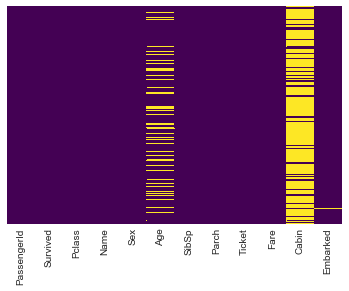

In [69]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

# An assessment of data available, Age and Cabin have missing values while the rest
# are relatively OK.


#### Visualizing some more of the data

analysis by column. By Survival

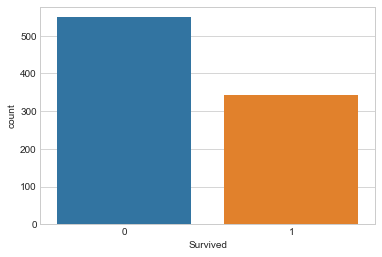

In [70]:
sns.countplot(x='Survived',data=train)

#### Survival by Gender

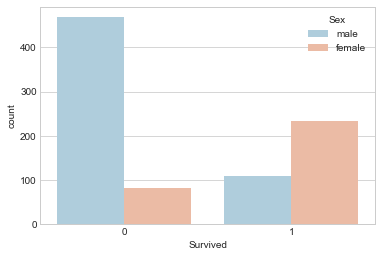

In [71]:
sns.countplot(x='Survived',hue='Sex',data=train,palette='RdBu_r')

#### Survival by Passenger Class

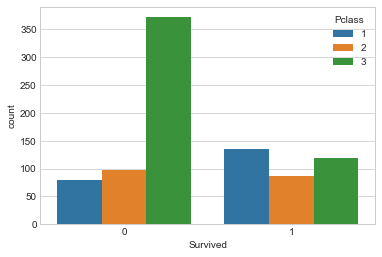

In [72]:
sns.countplot(x='Survived',hue='Pclass',data=train)

#### Distribution of Passengers on board by Age

/Users/4bic/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


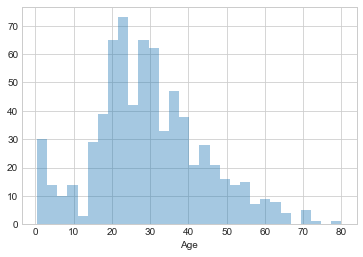

In [73]:
sns.distplot(train['Age'].dropna(),kde=False,bins=30)

#### Passengers onboard with sibling(s) / spouse

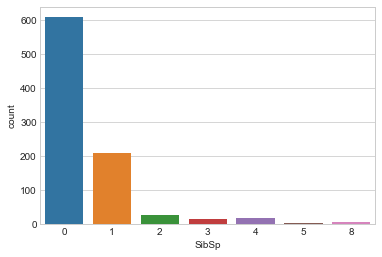

In [74]:
sns.countplot(x='SibSp',data=train)

#### Passengers by amount of fare paid

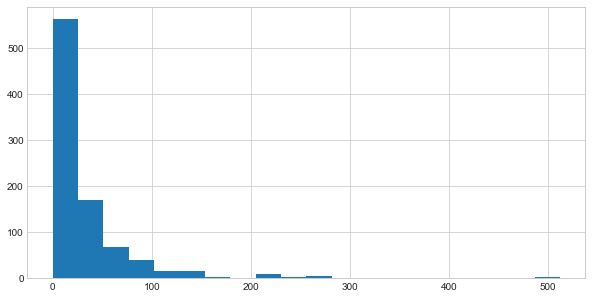

In [75]:
train['Fare'].hist(bins=20,figsize=(10,5))

# Data Cleaning

#### Imputation.  
    Filling out missing values by approximation
Filling in the mean age to the age column

Start of by checking the average age by passenger class.

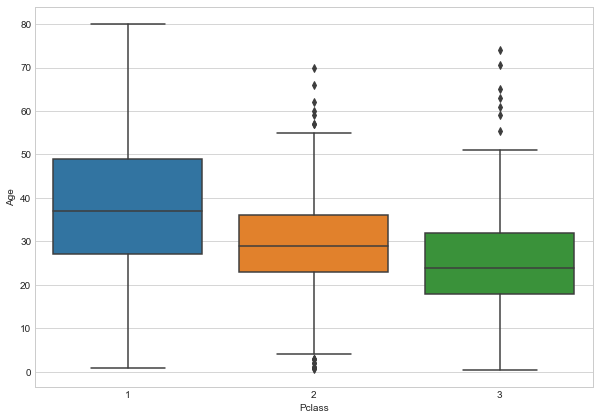

In [151]:
plt.figure(figsize=(10,7))
sns.boxplot(x='Pclass',y='Age',data=train)

Wealthier passengers in the higher classes tend to be older, 

We'll use these average age values to impute missing data based on Pclass for Age.

In [152]:
def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):
        if Pclass == 1:
            return 37
        elif Pclass == 2:
            return 29
        else:
            return 24
        
    else:
        return Age
            

Apply `impute_age` function

In [153]:
train['Age'] = train[['Age','Pclass']].apply(impute_age,axis=1)


And by checking for missing values on our data, we have;

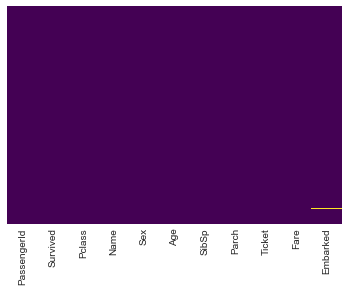

In [154]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')


We can Drop the `Cabin` column as it possesses a huge percentage of missing values and filling
in may not be appropriatte. 

Also we will drop the few instances on the `Embarked` column


In [ ]:
# train.drop('Cabin',axis=1,inplace=True)

In [156]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(4)
memory usage: 76.6+ KB


In [157]:
train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C


In [159]:
# train['Embarked'].fillna('S', inplace=True)

## Convert Categorical Features 

We need to convert categorical features to dummy variables using pandas,

Otherwise the learning algorithm won't be able to directly take in those features as inputs.

For the sex column, caterorize if passenger is male or not(1 | 0 )

On embarkment point it will be Q, S 0r C. 

In [160]:
sex = pd.get_dummies(train['Sex'],drop_first=True)

embark = pd.get_dummies(train['Embarked'],drop_first=True)

#### Concatenate the generated categorical columns to the dataset 

In [161]:
train = pd.concat([train, sex,embark],axis=1)
train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,male,Q,S
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,1,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,0,0,0


#### Select Columns that we will use for the model

In [168]:
train.drop(['Name','Sex','Embarked','Ticket'],axis=1,inplace=True)
# train.drop('PassengerId',axis=1,inplace=True)

In [169]:
train.head(2)

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,0,3,22.0,1,0,7.2500,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0


## Prep the test Set

In [171]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Age            418 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Fare           418 non-null float64
male           418 non-null uint8
Q              418 non-null uint8
S              418 non-null uint8
dtypes: float64(2), int64(4), uint8(3)
memory usage: 20.9 KB


In [141]:
test_df['Fare'].fillna(test_df['Fare'].mean(), inplace=True)
test_df['Age'].fillna(test_df['Age'].mean(), inplace=True)

In [144]:
sex_t = pd.get_dummies(test_df['Sex'],drop_first=True)

embark_t = pd.get_dummies(test_df['Embarked'],drop_first=True)

In [145]:
test_df = pd.concat([test_df, sex_t,embark_t],axis=1)
test_df.drop(['Name','Sex','Embarked','Ticket','Cabin'],axis=1,inplace=True)
test_df.head(2)

,PassengerId,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,892,3,34.5,0,0,7.8292,1,1,0
1,893,3,47.0,1,0,7.0000,0,0,1


In [172]:
test_df.head(2)

,PassengerId,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,892,3,34.5,0,0,7.8292,1,1,0
1,893,3,47.0,1,0,7.0000,0,0,1


And the data is ready for our model!


# Building a Logistic Regression model

Start by splitting data into a training set and test set 


## Train Test Split



    X = These are the features we will use to predict

    y = Value we are predicting ie Did the passenger survive

In [147]:
X = train.drop('Survived',axis=1)
y = train['Survived']

In [173]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
PassengerId    891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 76.6+ KB


### Prep the test dataset

In [106]:
from sklearn.model_selection import train_test_split

In [174]:
X_train = train.drop('Survived',axis=1)
y_train = train['Survived']

In [175]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
Pclass    891 non-null int64
Age       891 non-null float64
SibSp     891 non-null int64
Parch     891 non-null int64
Fare      891 non-null float64
male      891 non-null uint8
Q         891 non-null uint8
S         891 non-null uint8
dtypes: float64(2), int64(3), uint8(3)
memory usage: 37.5 KB


In [176]:
X_test  = test_df.drop('PassengerId',axis=1)

In [177]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
Pclass    418 non-null int64
Age       418 non-null float64
SibSp     418 non-null int64
Parch     418 non-null int64
Fare      418 non-null float64
male      418 non-null uint8
Q         418 non-null uint8
S         418 non-null uint8
dtypes: float64(2), int64(3), uint8(3)
memory usage: 17.6 KB


## Training and Predicting

In [178]:
from sklearn.linear_model import LogisticRegression

In [179]:
# create an instance of LR model
logmodel = LogisticRegression()

In [180]:
# train the model

logmodel.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [181]:
# predict using the model
predictions = logmodel.predict(X_test)

In [182]:
len(predictions)

418

In [188]:
# Generate Submission File 
Submission = pd.DataFrame({ 'PassengerId': test_df['PassengerId'],
                            'Survived': predictions })
Submission.to_csv("4bic_titanic_submission.csv", index=False)